In [14]:
import pandas as pd
import numpy as np
import os
from os import listdir
from os.path import isfile, join
from PIL import ImageFile
import skimage
from skimage import io, transform
import matplotlib.pyplot as plt
import scipy.misc as m
ImageFile.LOAD_TRUNCATED_IMAGES = True
from torch.utils import data
from dataset import PlacesDataset
from data_dicts import Dicts
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [2]:
dic=Dicts()
train_files,val_files=dic.get_dicts()

In [8]:
def showimage(image,tor):
    if tor==1:
        image=image.numpy().transpose(1,2,0)
        image=image[:,:,::-1]
    plt.imshow(image)
    plt.show()

In [4]:
train_dataset=PlacesDataset(train_files,augment=0,transforms=True)
val_dataset=PlacesDataset(val_files,augment=10,transforms=True)

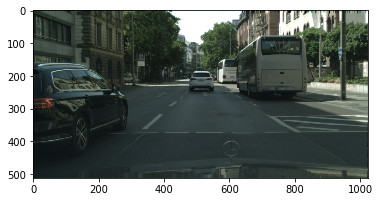

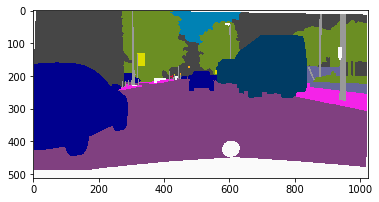

In [12]:
img,label=val_dataset[150]
showimage(img,1)
showimage(train_dataset.decode_segmap(label.numpy()),0)

In [13]:
train_loader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=2)
validation_loader = torch.utils.data.DataLoader(val_dataset,batch_size=1)

In [15]:
class Unet(nn.Module):
    def __init__(self):
        super(Unet,self).__init__()
        self.conv1a=nn.Sequential(nn.Conv2d(3,64,3,1,0),nn.BatchNorm2d(64),nn.ReLU())
        self.conv1b=nn.Sequential(nn.Conv2d(64,64,3,1,0),nn.BatchNorm2d(64),nn.ReLU())
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        self.conv2a=nn.Sequential(nn.Conv2d(64,128,3,1,0),nn.BatchNorm2d(128),nn.ReLU())
        self.conv2b=nn.Sequential(nn.Conv2d(128,128,3,1,0),nn.BatchNorm2d(128),nn.ReLU())
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        self.conv3a=nn.Sequential(nn.Conv2d(128,256,3,1,0),nn.BatchNorm2d(256),nn.ReLU())
        self.conv3b=nn.Sequential(nn.Conv2d(256,256,3,1,0),nn.BatchNorm2d(256),nn.ReLU())
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        
        self.conv4a=nn.Sequential(nn.Conv2d(256,512,3,1,0),nn.BatchNorm2d(512),nn.ReLU())
        self.conv4b=nn.Sequential(nn.Conv2d(512,512,3,1,0),nn.BatchNorm2d(512),nn.ReLU())
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)
        
        self.conv5a=nn.Sequential(nn.Conv2d(512,1024,3,1,0),nn.BatchNorm2d(1024),nn.ReLU())
        self.conv5b=nn.Sequential(nn.Conv2d(1024,1024,3,1,0),nn.BatchNorm2d(1024),nn.ReLU())
        
        self.up1=nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv6a=nn.Sequential(nn.Conv2d(1024,512,3,1,0),nn.BatchNorm2d(512),nn.ReLU())
        self.conv6b=nn.Sequential(nn.Conv2d(512,512,3,1,0),nn.BatchNorm2d(512),nn.ReLU())
        
        self.up2=nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv7a=nn.Sequential(nn.Conv2d(512,256,3,1,0),nn.BatchNorm2d(256),nn.ReLU())
        self.conv7b=nn.Sequential(nn.Conv2d(256,256,3,1,0),nn.BatchNorm2d(256),nn.ReLU())
        
        self.up3=nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv8a=nn.Sequential(nn.Conv2d(256,128,3,1,0),nn.BatchNorm2d(128),nn.ReLU())
        self.conv8b=nn.Sequential(nn.Conv2d(128,128,3,1,0),nn.BatchNorm2d(128),nn.ReLU())
        
        self.up4=nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv9a=nn.Sequential(nn.Conv2d(128,64,3,1,0),nn.BatchNorm2d(64),nn.ReLU())
        self.conv9b=nn.Sequential(nn.Conv2d(64,64,3,1,0),nn.BatchNorm2d(64),nn.ReLU())
        
        self.conv9_final=nn.Conv2d(64,21,1)
        
    def forward(self,input_image):
        conv1=self.conv1b(self.conv1a(input_image))
        o1=self.maxpool1(conv1)
        
        conv2=self.conv2b(self.conv2a(o1))
        o2=self.maxpool2(conv2)
        
        conv3=self.conv3b(self.conv3a(o2))
        o3=self.maxpool3(conv3)
        
        conv4=self.conv4b(self.conv4a(o3))
        o4=self.maxpool4(conv4)
        
        conv5=self.up1(self.conv5b(self.conv5a(o4)))
        
        conv6=self.up2(self.conv6b(self.conv6a(self.merge(conv5,conv4))))
        conv7=self.up3(self.conv7b(self.conv7a(self.merge(conv6,conv3))))
        conv8=self.up4(self.conv8b(self.conv8a(self.merge(conv7,conv2))))
        conv9=self.conv9_final(self.conv9b(self.conv9a(self.merge(conv8,conv1))))
        
        return conv9
        
    def merge(self,outputs,inputs):
        offset = outputs.size()[2] - inputs.size()[2]
        padding = 2 * [offset // 2, offset // 2]
        output = F.pad(inputs, padding)
        return torch.cat([output,outputs],1)

In [16]:
unet=Unet()